In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import project_utils

Importo i dati

In [3]:
df = pd.read_csv("../data/windows_hi.csv")

In [4]:
df.head()

,Finestra,batterie,inverter,conversione,scaricatori,controllo,raffreddamento
0,1,0.5114,0.5269,0.5009,0.5371,0.5012,0.5234
1,2,0.5229,0.5070,0.5098,0.5371,0.5256,0.5330
2,3,0.5126,0.5180,0.5133,0.5170,0.5090,0.5323
3,4,0.5063,0.5067,0.5058,0.5170,0.5022,0.5185
4,5,0.5174,0.4994,0.5007,0.5371,0.5265,0.5120


Breve descrizione delle variabili

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Finestra        499 non-null    int64  
 1   batterie        499 non-null    float64
 2   inverter        499 non-null    float64
 3   conversione     499 non-null    float64
 4   scaricatori     499 non-null    float64
 5   controllo       499 non-null    float64
 6   raffreddamento  499 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 27.4 KB


Time series plots with moving average and median

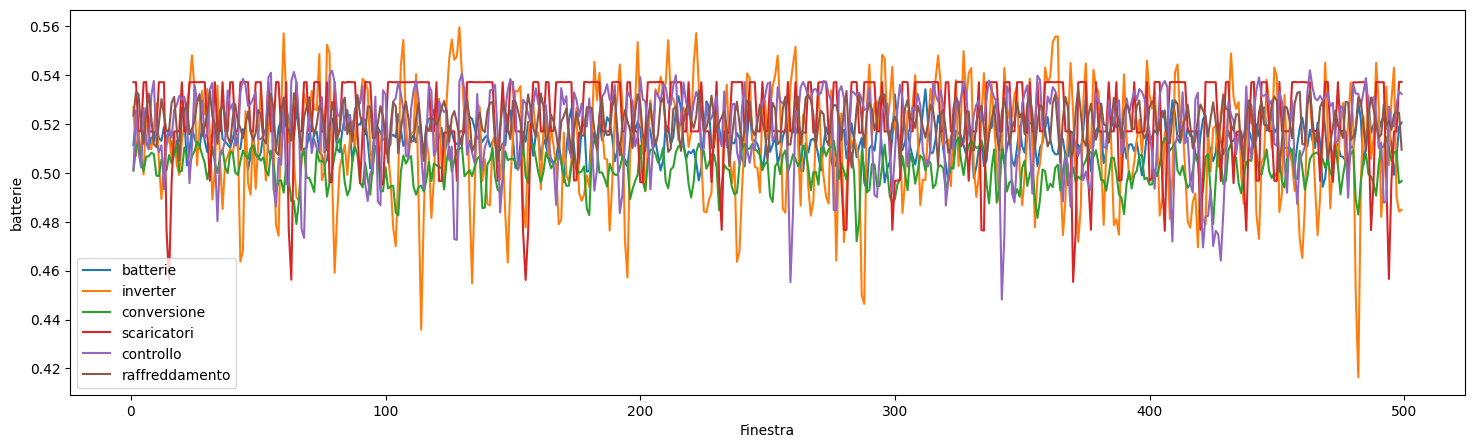

In [6]:
f, ax = plt.subplots(figsize = (18, 5))

for i, column in enumerate(df.drop('Finestra', axis = 1).columns):
    sns.lineplot(x = df['Finestra'], y = df[column], label = column)

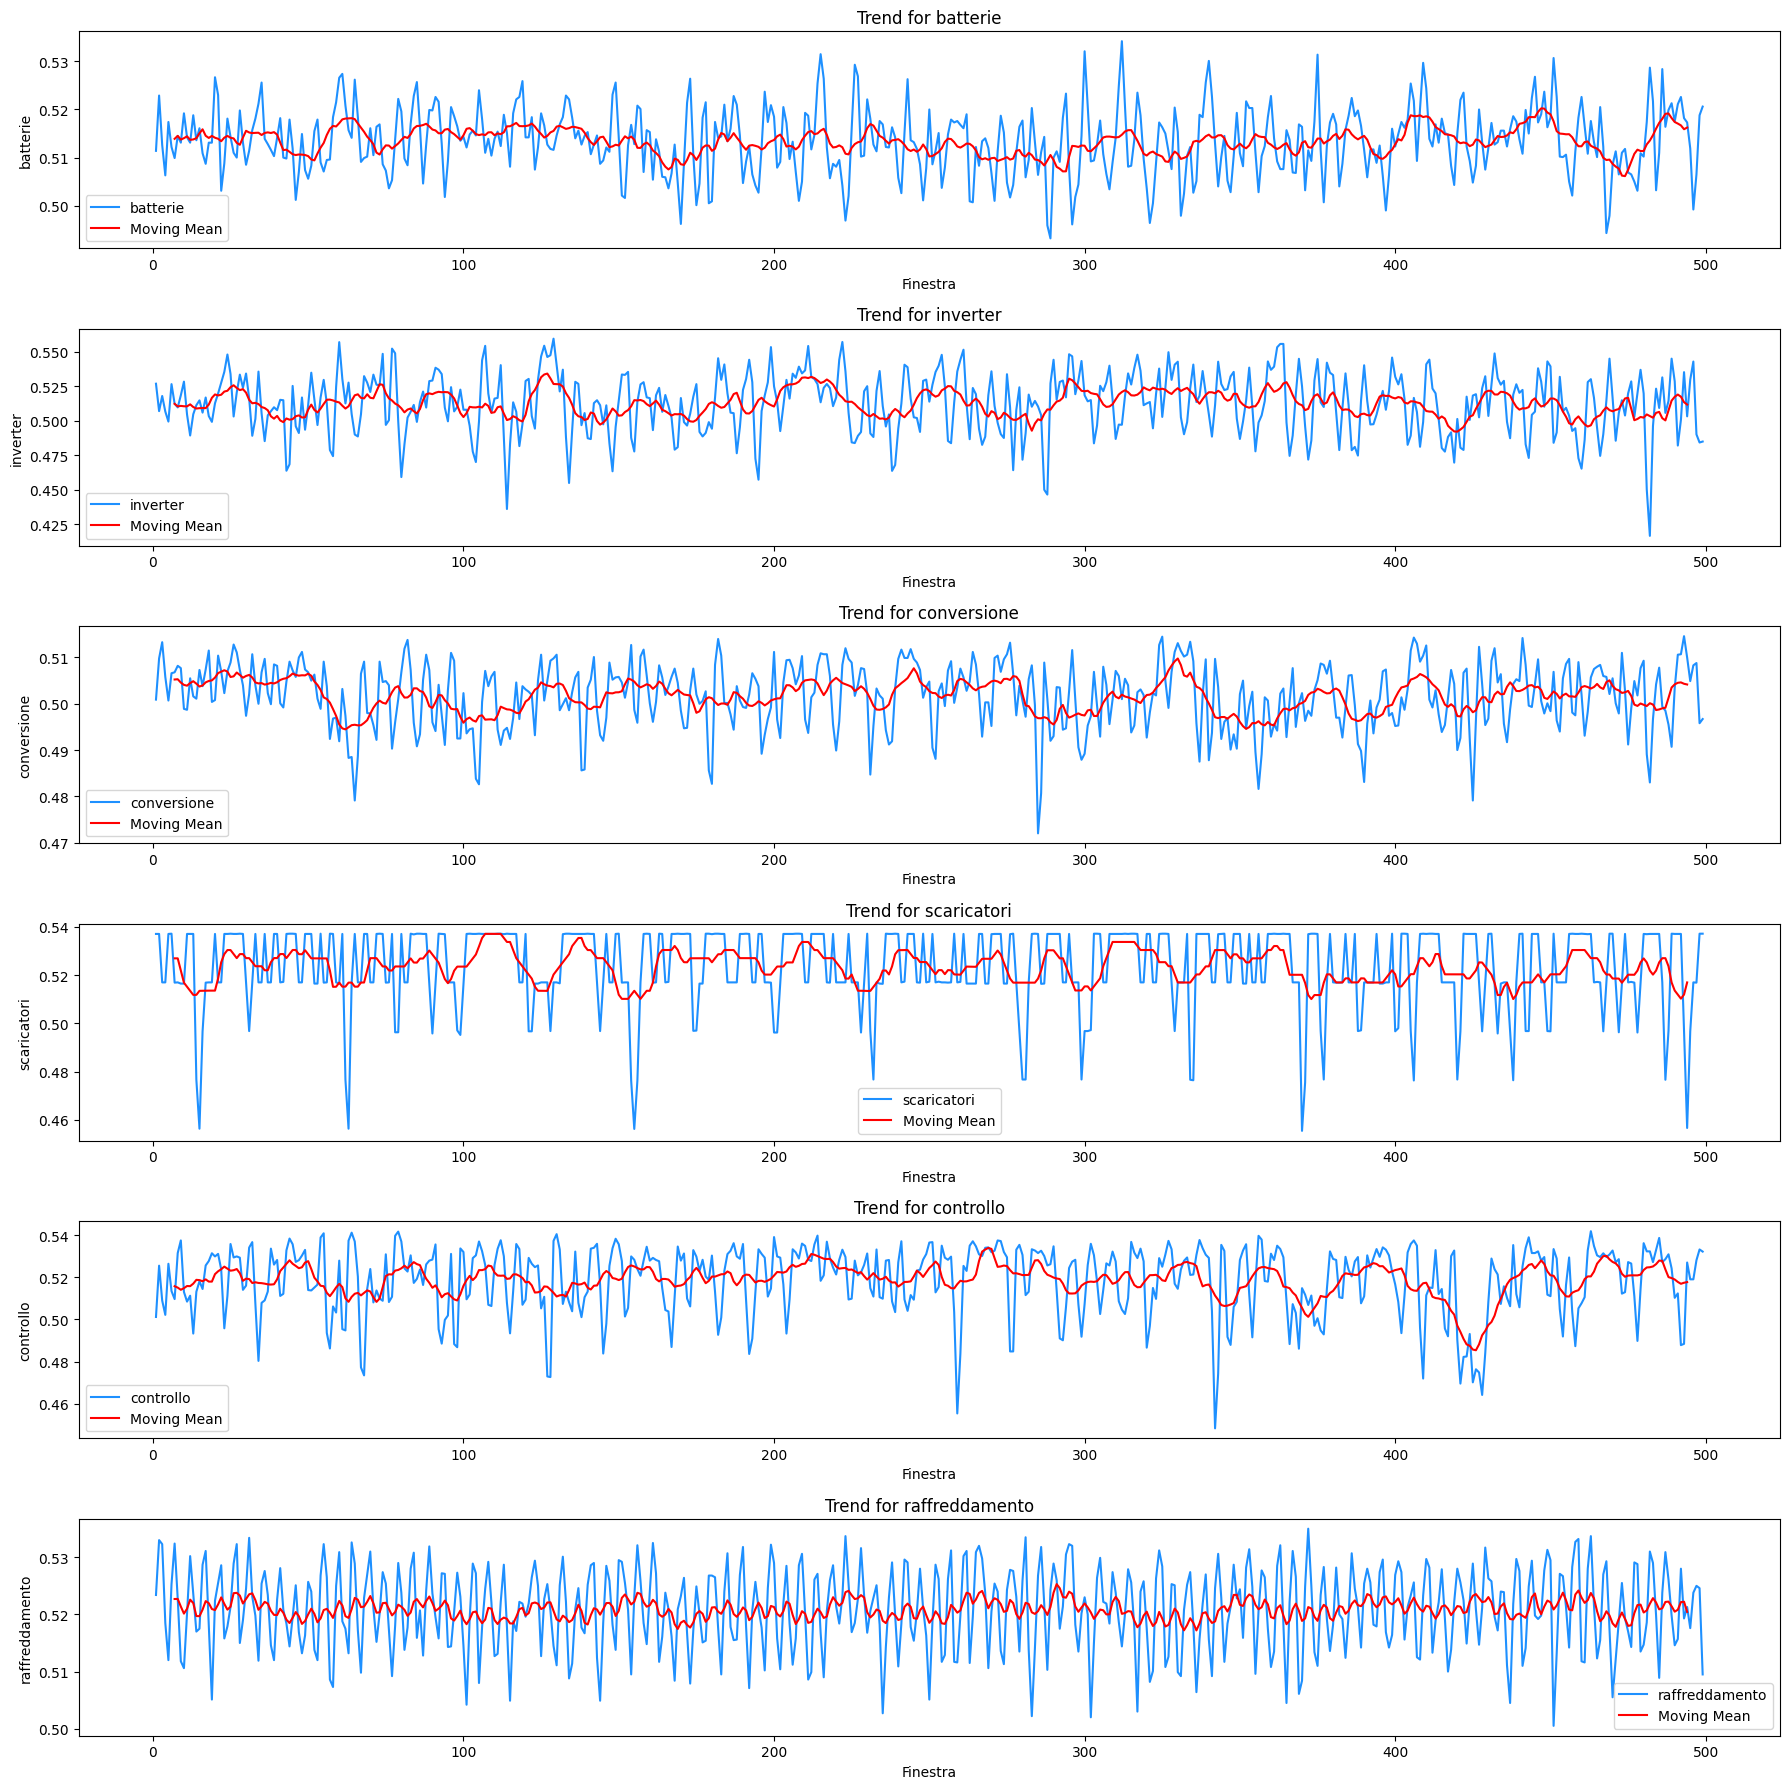

In [7]:
project_utils.plot_time_series_with_rolling(df,'Finestra', window_length=12, include_median=False, include_std=False)

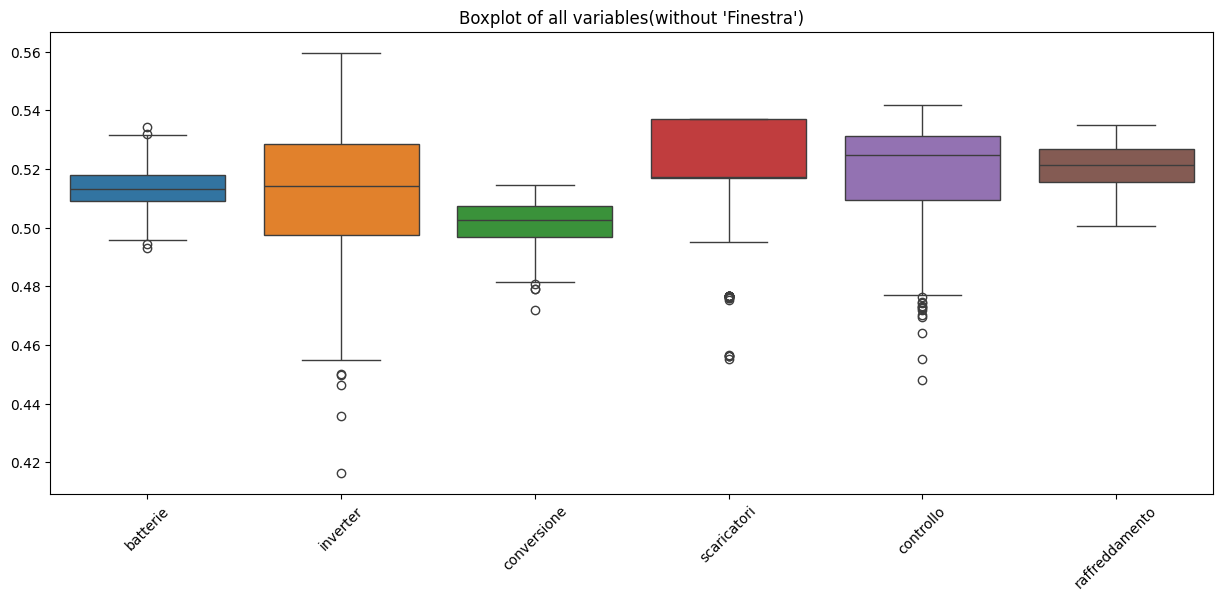

In [8]:
#Select all variables but windows
numeric_cols = df.select_dtypes(include='number').drop(columns=['Finestra'])

# Boxplot 
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_cols)
plt.xticks(rotation=45)
plt.title("Boxplot of all variables(without 'Finestra')")
plt.show()


Histograms and QQ-plots of the variables to observe their distributions and potential normality

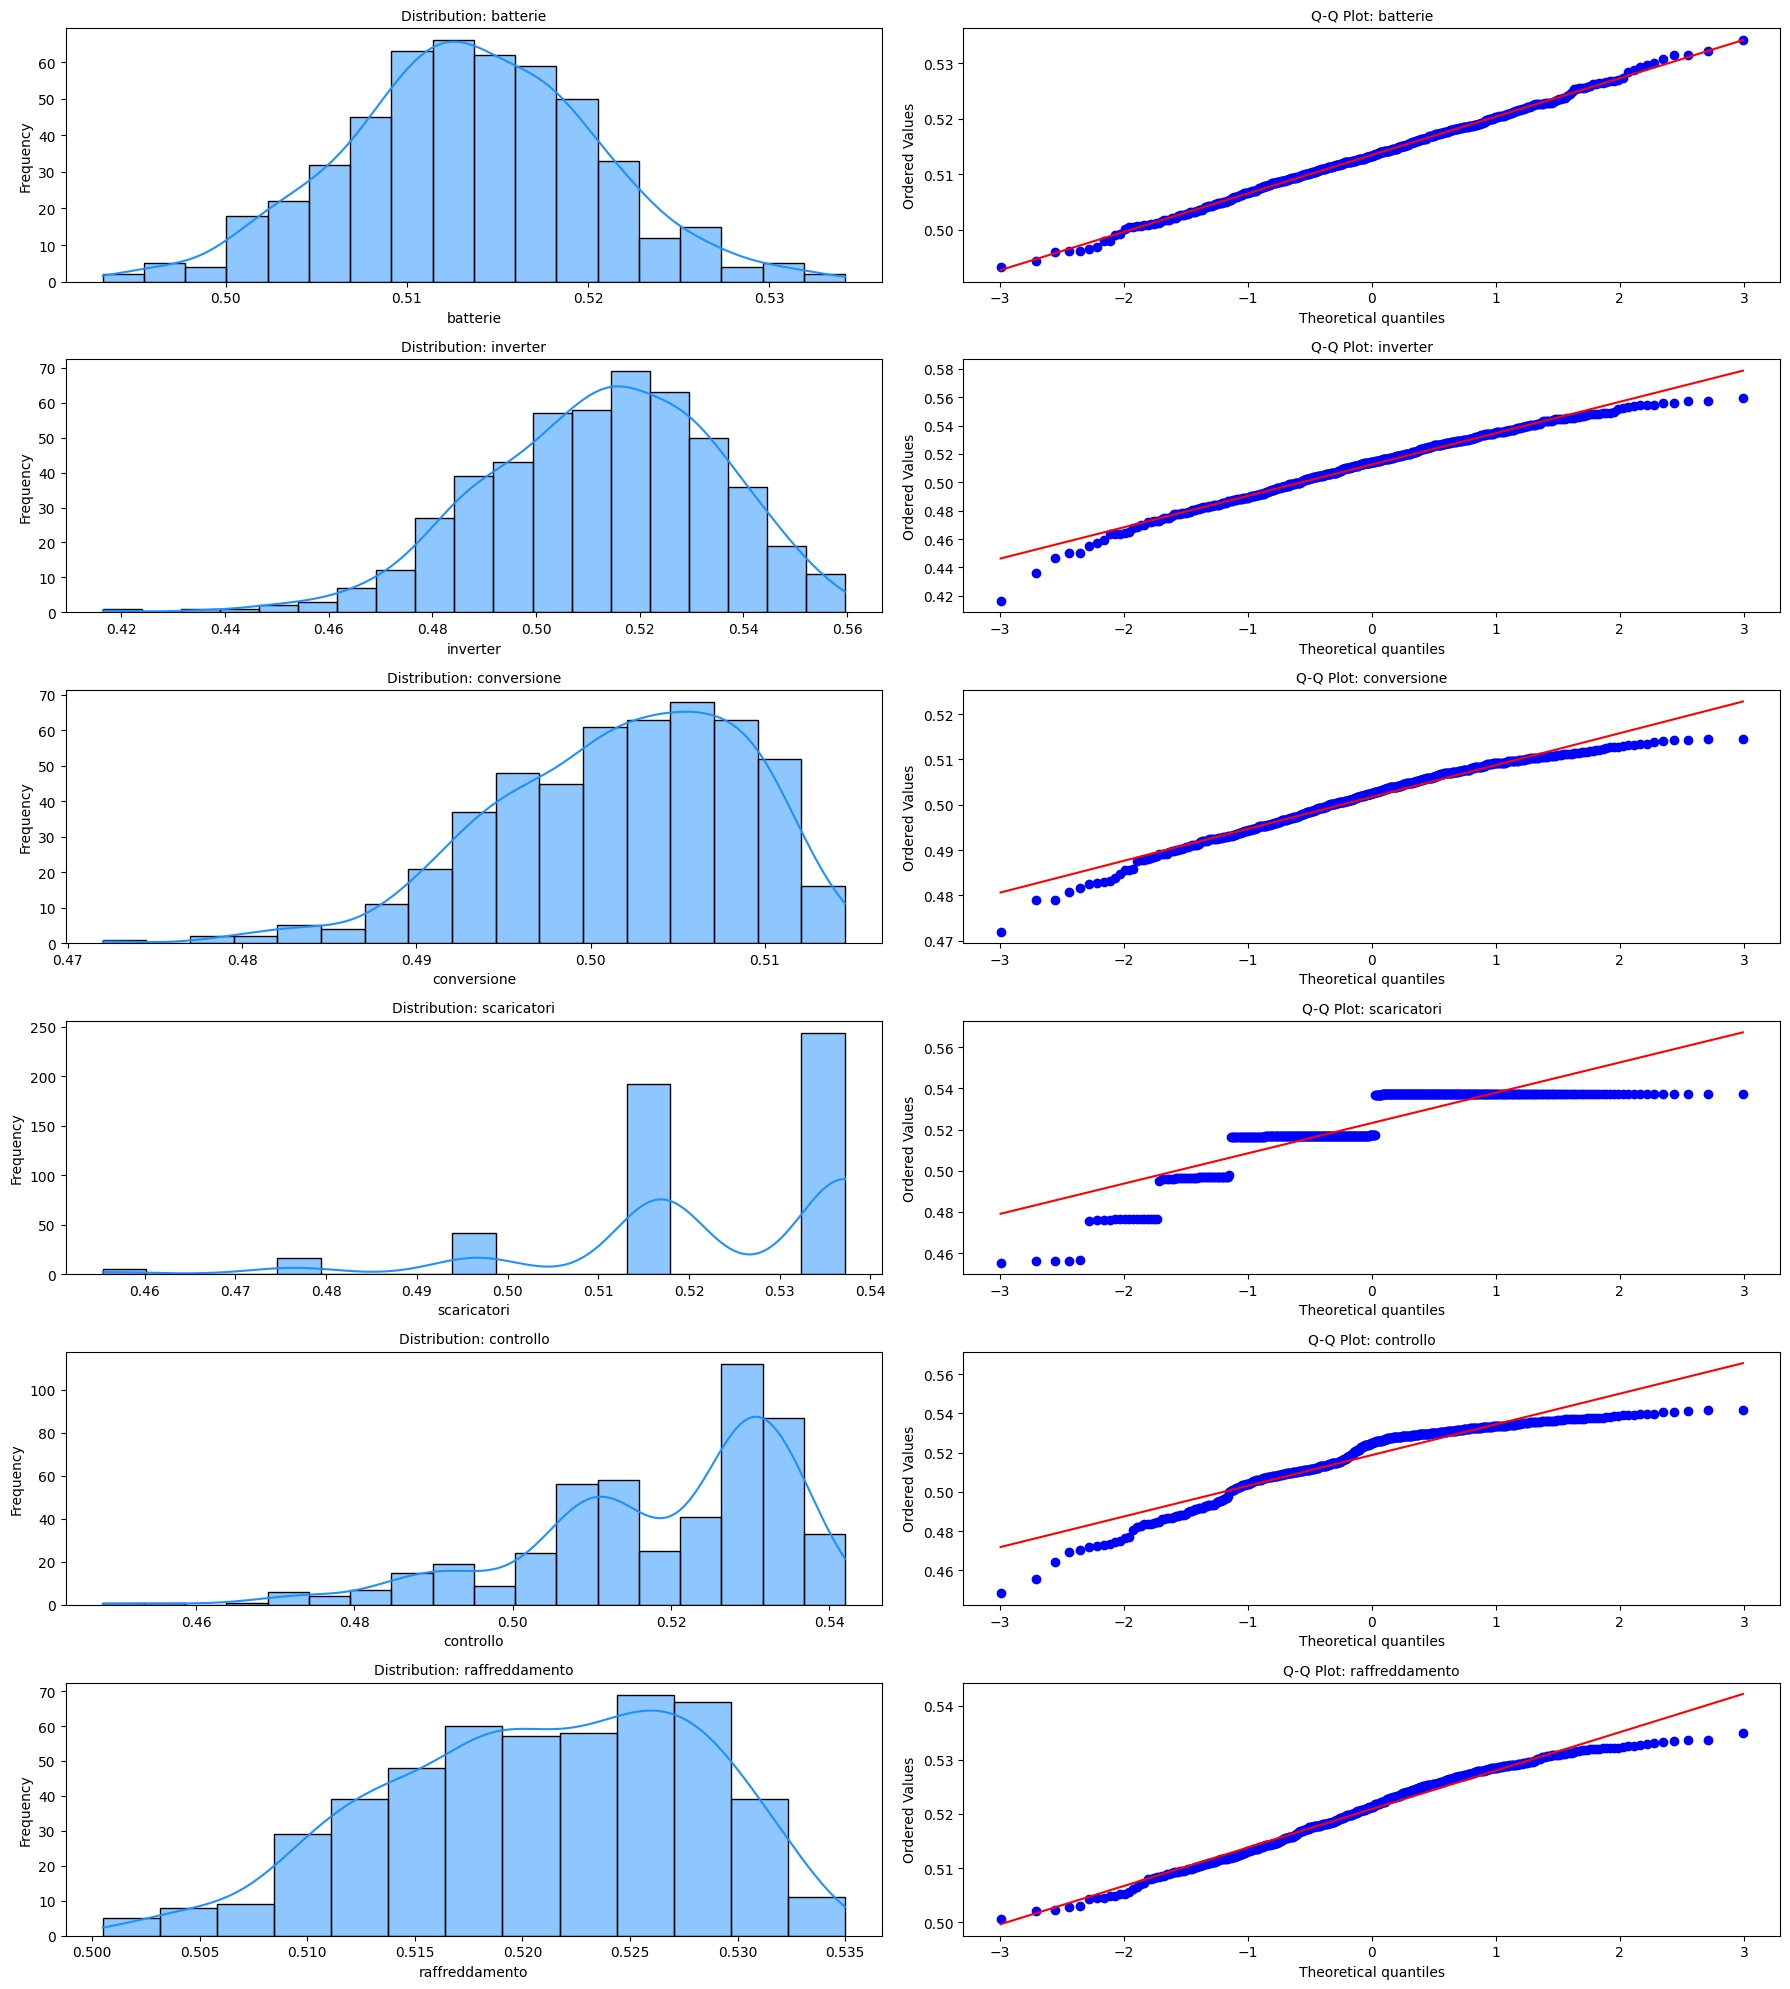

In [ ]:
project_utils.plot_distributions_and_qq(df,'Finestra')

Note: The variable "scaricatori" is discrete because it was created as the output of an autoencoder that takes two categorical variables as input.

Normality Test (Shapiro-Wilk)

In [10]:
from scipy.stats import shapiro, normaltest
from statsmodels.tsa.stattools import adfuller

variabili = ['batterie', 'inverter', 'conversione', 'scaricatori', 'controllo', 'raffreddamento']

for var in variabili:
    print(f"\n▶ Variables: {var}")

    #Shapiro-Wilk Test (normality)
    try:
        stat_sw, p_sw = shapiro(df[var])
        print(f"  Shapiro-Wilk: stat={stat_sw:.3f}, p={p_sw:.3f} → {'✓ Normal' if p_sw > 0.05 else '✗ Not normal'}")
    except:
        print("  Shapiro-Wilk: error (dimensionality too high?)")


▶ Variables: batterie
  Shapiro-Wilk: stat=0.998, p=0.912 → ✓ Normal

▶ Variables: inverter
  Shapiro-Wilk: stat=0.985, p=0.000 → ✗ Not normal

▶ Variables: conversione
  Shapiro-Wilk: stat=0.969, p=0.000 → ✗ Not normal

▶ Variables: scaricatori
  Shapiro-Wilk: stat=0.755, p=0.000 → ✗ Not normal

▶ Variables: controllo
  Shapiro-Wilk: stat=0.902, p=0.000 → ✗ Not normal

▶ Variables: raffreddamento
  Shapiro-Wilk: stat=0.978, p=0.000 → ✗ Not normal


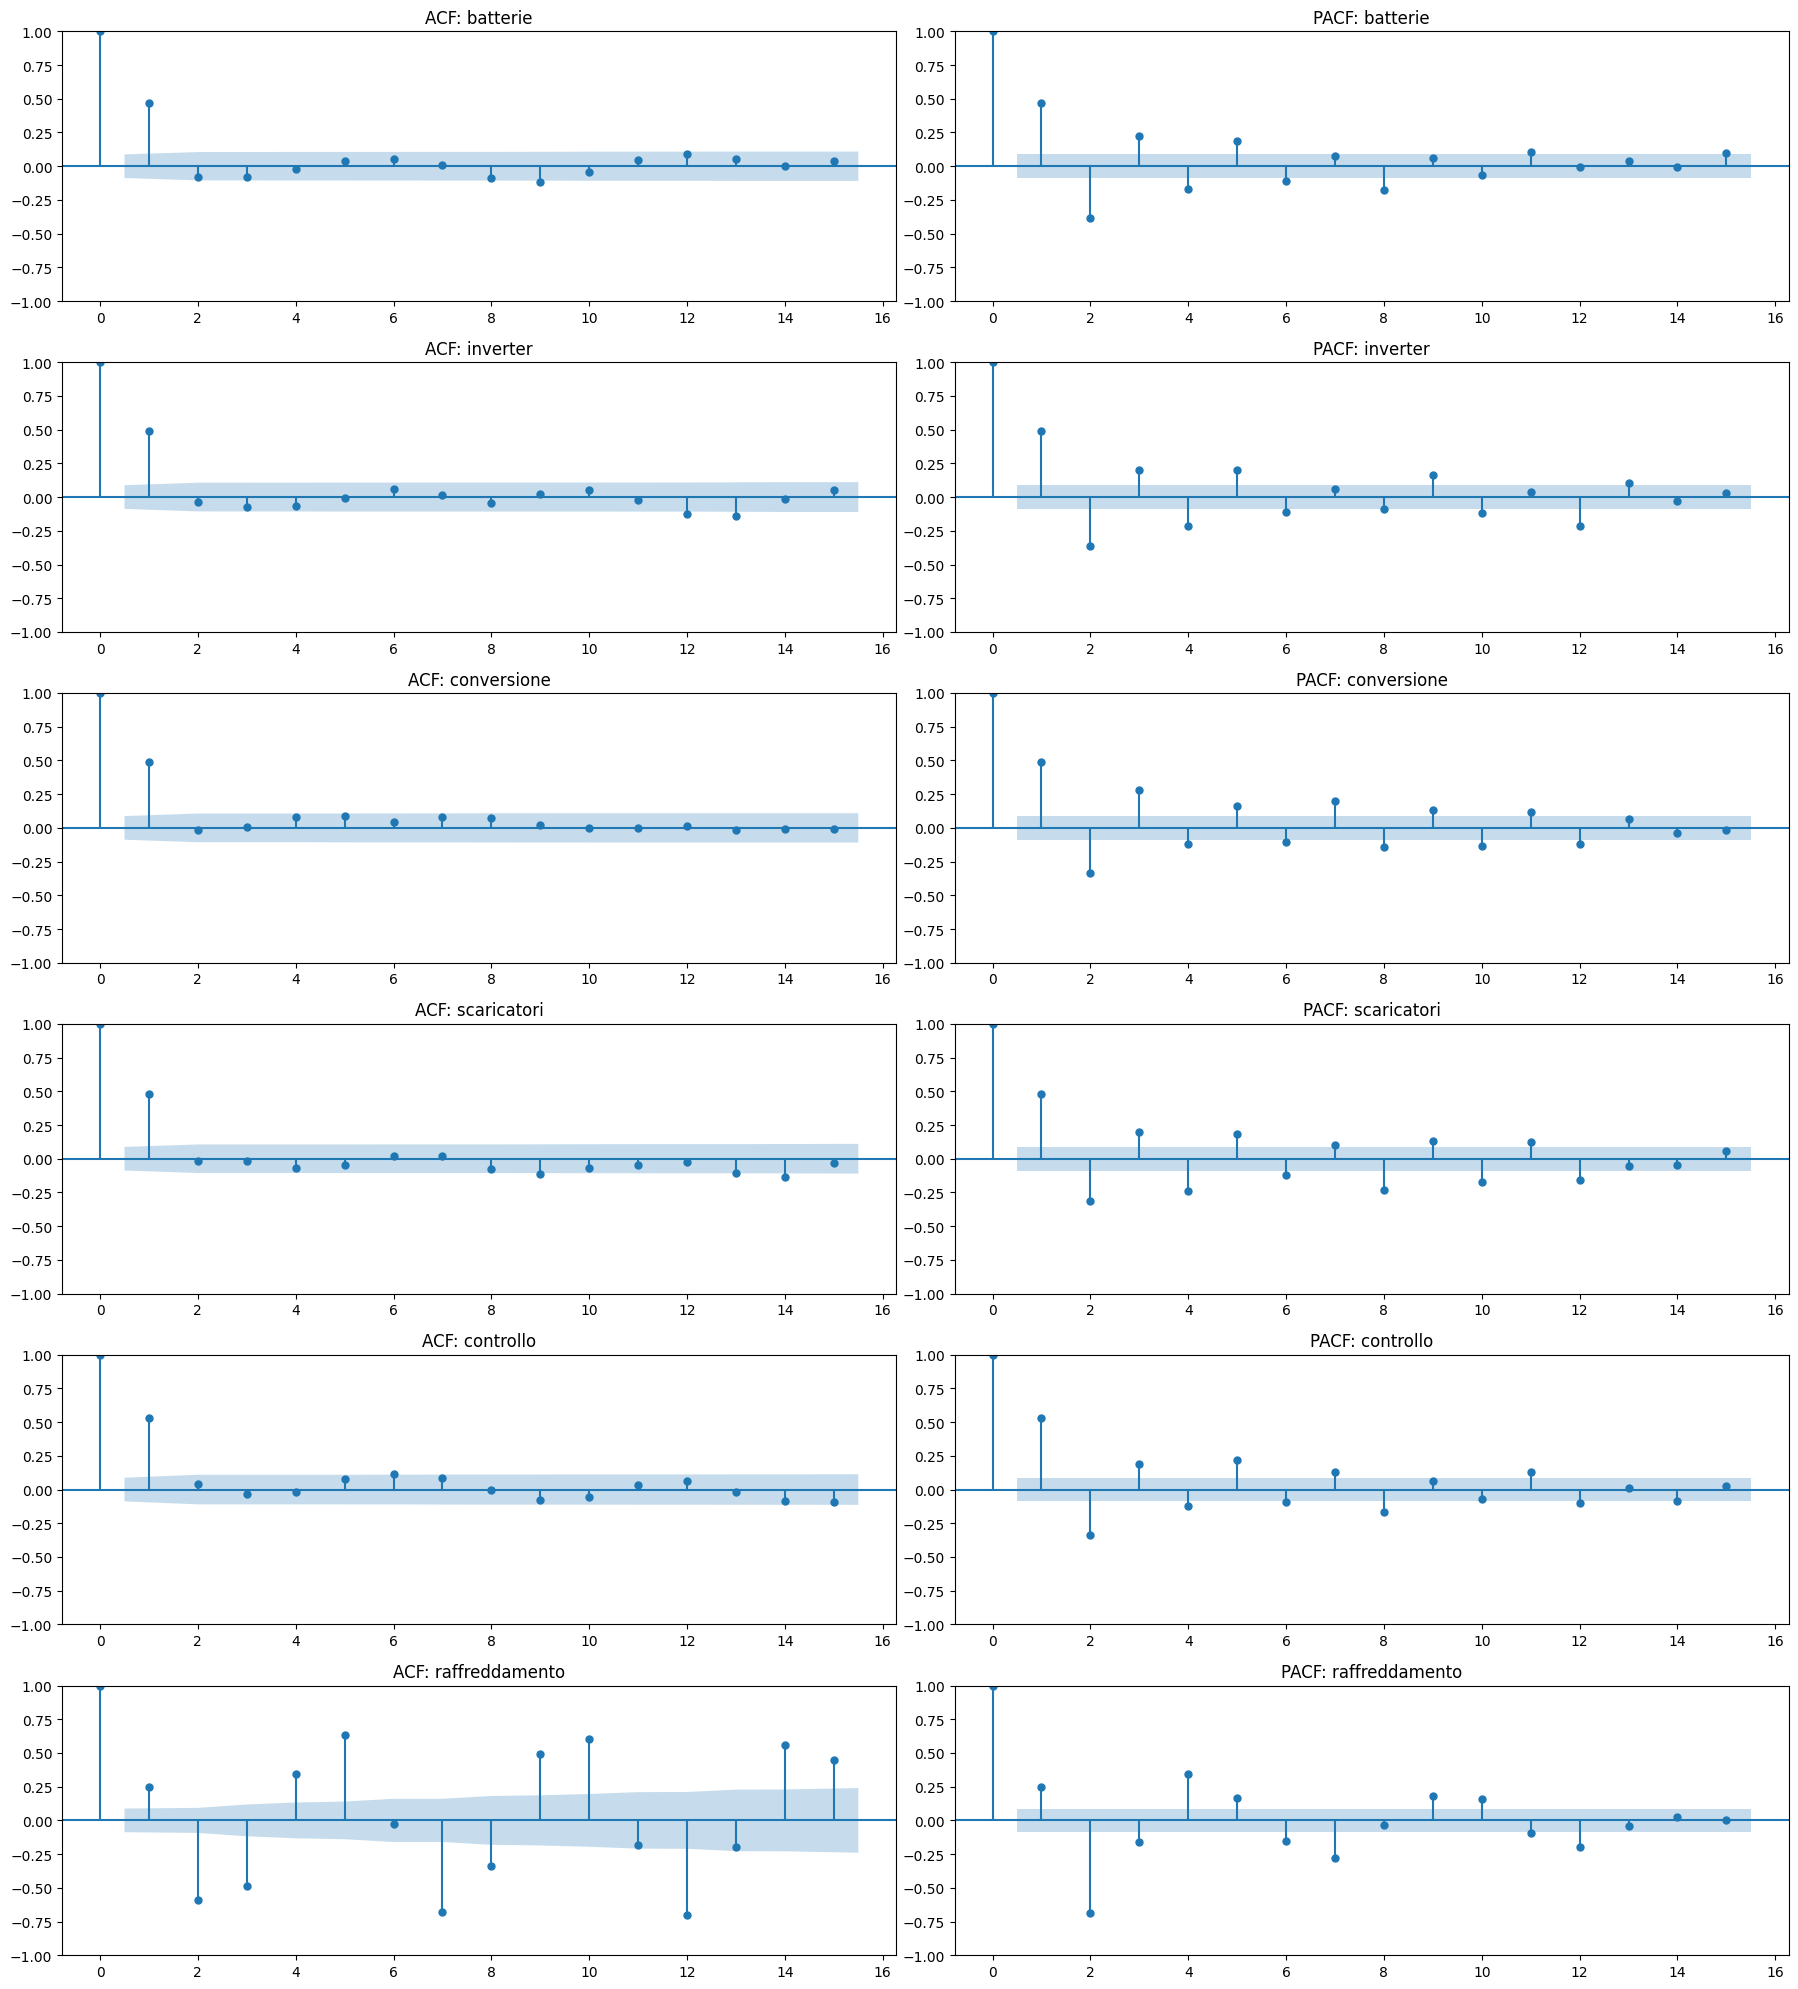

In [11]:
project_utils.plot_acf_pacf_matrix(df,'Finestra', lags=15)

ADF and KPSS tests for the stationarity of the series

In [12]:
df_stationarity = project_utils.stationarity_test(df,'Finestra')
display(df_stationarity)

c:\Users\HP\Desktop\Data\project_utils.py:143: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series.dropna(), regression='c', nlags='auto')
c:\Users\HP\Desktop\Data\project_utils.py:143: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series.dropna(), regression='c', nlags='auto')
c:\Users\HP\Desktop\Data\project_utils.py:143: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series.dropna(), regression='c', nlags='auto')
c:\Users\HP\Desktop\Data\project_utils.py:143: InterpolationWarning: The test statistic is outside of the range of p-v

,Variable,ADF p-value,ADF stationary?,KPSS p-value,KPSS stationary?
5,raffreddamento,1.629736e-11,✅ Yes,0.1,✅ Yes
3,scaricatori,1.455132e-10,✅ Yes,0.1,✅ Yes
1,inverter,2.807228e-08,✅ Yes,0.1,✅ Yes
2,conversione,6.491214e-06,✅ Yes,0.1,✅ Yes
0,batterie,6.634819e-05,✅ Yes,0.1,✅ Yes
4,controllo,1.354692e-04,✅ Yes,0.1,✅ Yes


Since the ACF shows no apparent seasonality, we perform an STL decomposition with a period of 2 in order to isolate the trend from the noise.

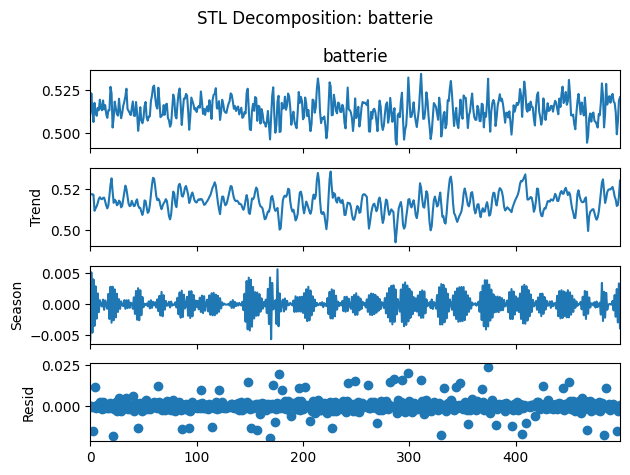

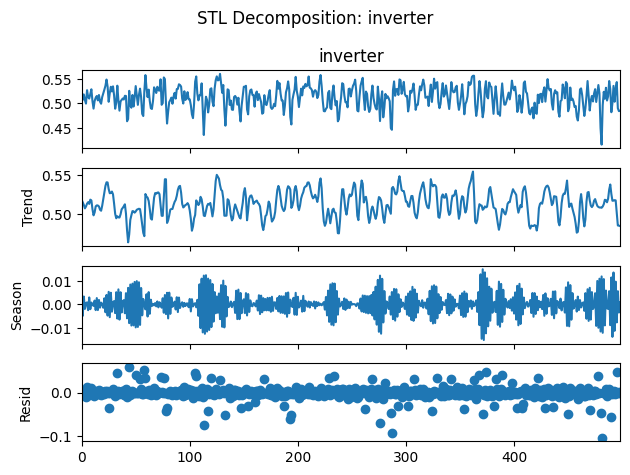

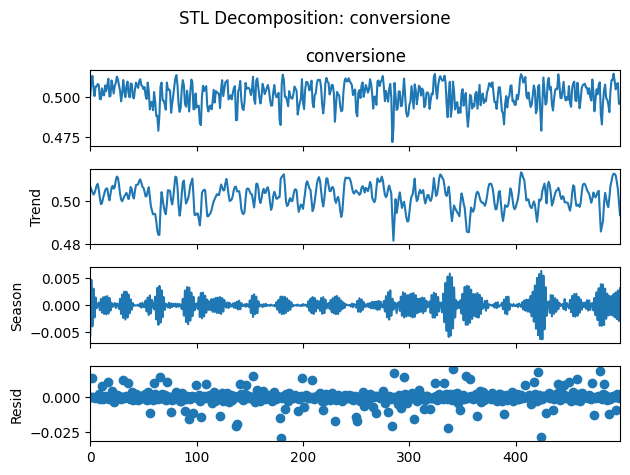

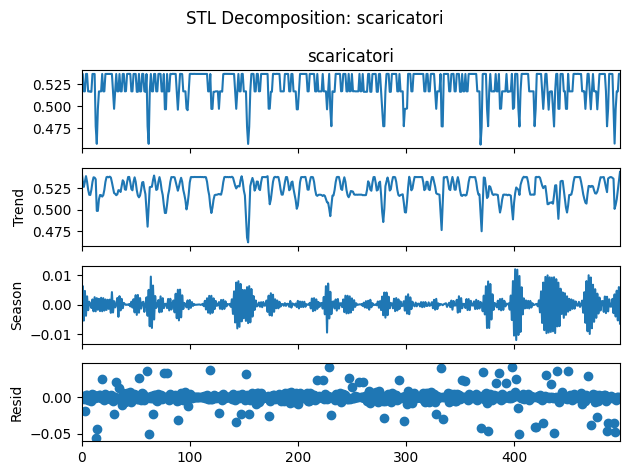

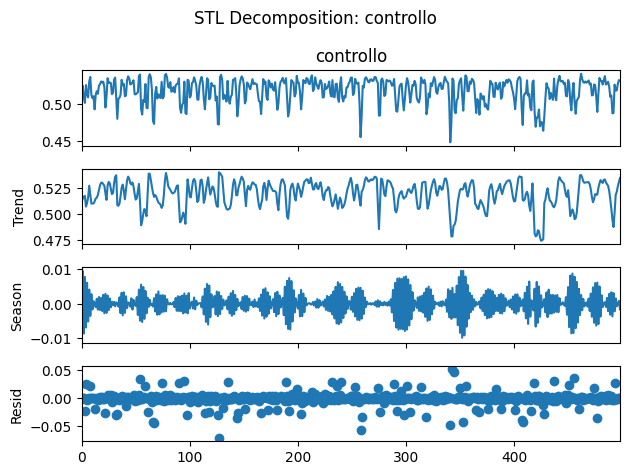

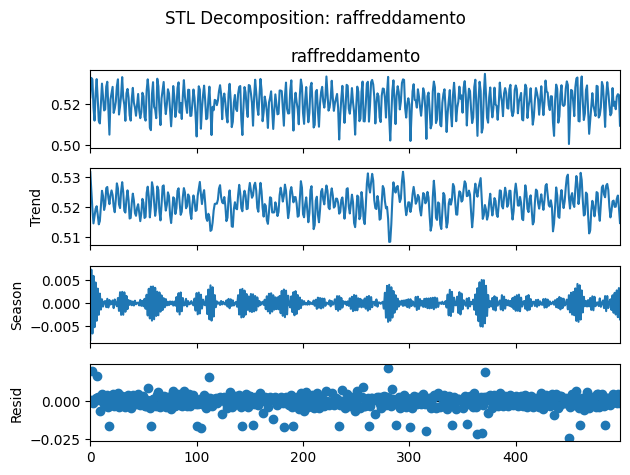

In [13]:
from statsmodels.tsa.seasonal import STL

for col in df.columns:
    if col != 'Finestra':
        serie = df[col].dropna()
        stl = STL(serie, period=2, robust=True)  
        result = stl.fit()
        result.plot()
        plt.suptitle(f'STL Decomposition: {col}')
        plt.tight_layout()
        plt.show()

The resulting trend components appear smooth and interpretable, while the seasonal components are negligible in magnitude and do not display any meaningful pattern. This confirms that the STL is effectively acting as a denoising tool in this context, rather than uncovering true seasonal behavior.

Pairplot of the variables to observe potential correlations

Pearson Coefficient

In [14]:
df_plot = df.drop(columns=["Finestra"])

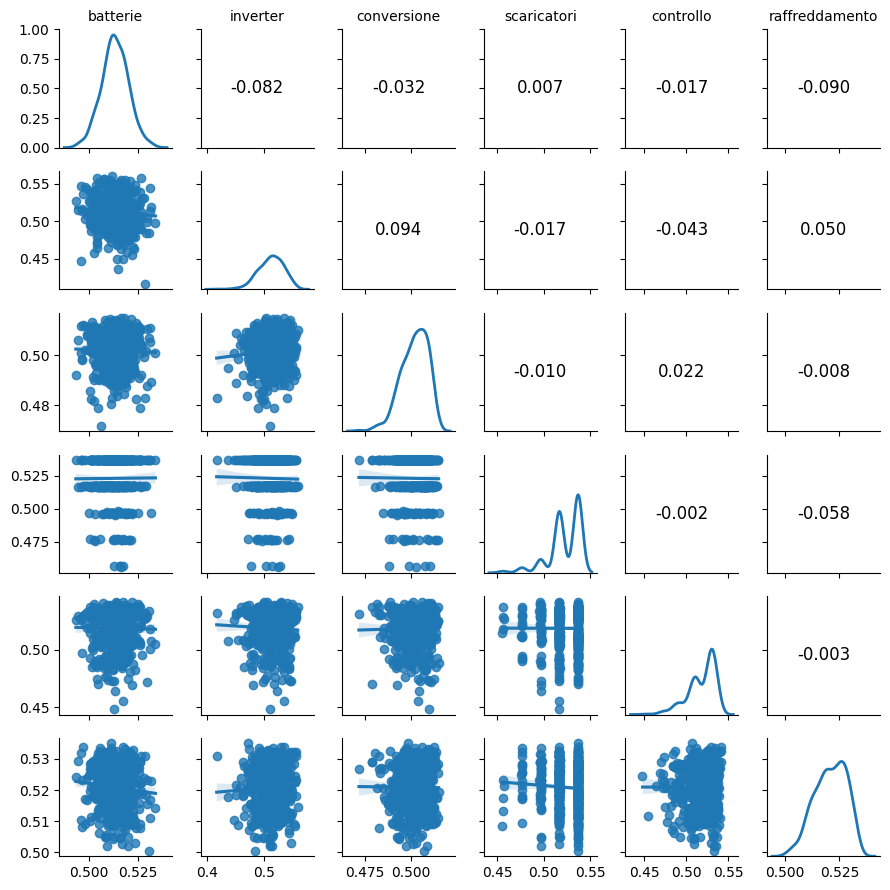

In [15]:
project_utils.pairwise_correlation_plot(
    df = df_plot,
    method='pearson',
    height=1.5,
    sig_level=0.01,
    diag_plot='kde',
    lower_plot='reg'
)

Spearman Coefficient

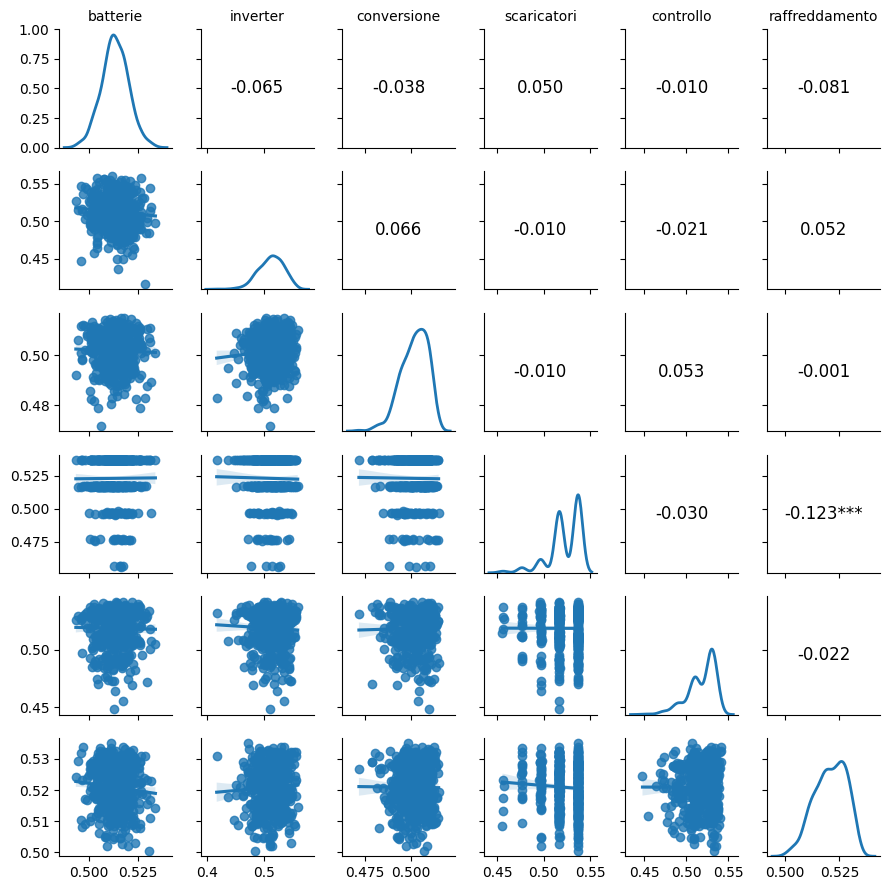

In [16]:
project_utils.pairwise_correlation_plot(
    df = df_plot,
    method='spearman',
    height=1.5,
    sig_level=0.01,
    diag_plot='kde',
    lower_plot='reg'
)